## Общая информация о датасете

Загрузим библиотеку Kaleido для создания статических изображений.

In [1]:
pip install kaleido

Note: you may need to restart the kernel to use updated packages.


In [2]:
# импортируем библиотеки

import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt
import scipy.stats as st
import matplotlib.pyplot as plt
import re
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
from plotly.offline import iplot

In [3]:
# диаграммы, созданные с помощью библиотеки plotly, будем отображать в формате png

pio.renderers.default = "png"
svg_renderer = pio.renderers["png"]
svg_renderer.width = 1000
svg_renderer.height = 600

Для работы с графиками, обновим matplotlib.

In [4]:
pip install matplotlib --upgrade

Note: you may need to restart the kernel to use updated packages.


In [5]:
# читаем файл и добавляем в переменную 

df = pd.read_csv('C:\\Файлы\\ecom_dataset_upd.csv')

In [6]:
df.head()

,date,customer_id,order_id,product,quantity,price
0,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0
1,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0
2,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0
3,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0
4,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0


In [7]:
# выведем общую информацию о датафрейме

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7474 entries, 0 to 7473
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         7474 non-null   int64  
 1   customer_id  7474 non-null   object 
 2   order_id     7474 non-null   int64  
 3   product      7474 non-null   object 
 4   quantity     7474 non-null   int64  
 5   price        7474 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 350.5+ KB


Из общей информации мы видим следующее:
- названия столбцов соответствуют общепринятому стилю;
- кроме даты, верно определены типы данных;
- в данных нет пропусков.

In [8]:
# приведем тип данных столбца date к datetime

df['date'] = df['date'].astype('str').map(
    lambda x: dt.datetime.strptime(x, '%Y%m%d%H'))

In [9]:
df.dtypes

date           datetime64[ns]
customer_id            object
order_id                int64
product                object
quantity                int64
price                 float64
dtype: object

Узнаем как распределяются данные по годам.

In [10]:
df['date'].dt.year.value_counts()

2019    5783
2018    1422
2020     269
Name: date, dtype: int64

Больше всего данных приходится на 2019 год, меньше на 2020.

Выясним количество уникальных пользователей, заказов и наименований  товаров.

In [11]:
for c in ['customer_id', 'order_id', 'product']:
    print(c, df[c].nunique())

customer_id 2451
order_id 3521
product 2343


Построим гистограммы для столбцов с количественной информацией.

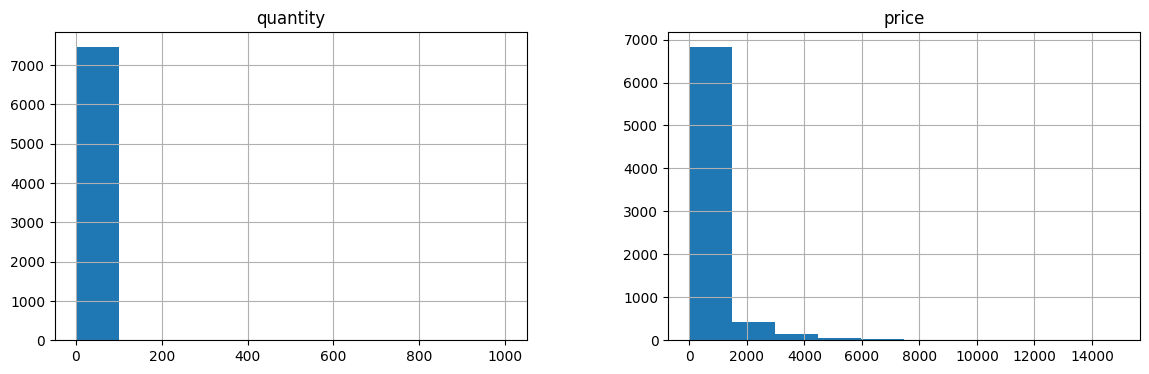

In [12]:
df[['quantity','price']].hist(figsize=(14,4))
plt.show()

На первый взгляд данные выглядят нормально. Будем смотреть дальше.

## Предобработка данных

Ранее мы обнаружили, что в данных отсутсвуют пропуски. Выполним проверку на дуликаты и аномалии.

### Поиск и обработка дубликатов

Первым делом попробуем сократить разные наименования одних и тех же товаров, если они есть.

In [13]:
df['product'].nunique()

2343

Всего у нас встречается 2343 уникальных наименований товаров.

In [14]:
# удалим лишние пробелы и приведем к нижнему регистру

df['product'] = df['product'].str.strip().str.lower()
list(df['product'].head(10))

['комнатное растение в горшке алое вера, d12, h30',
 'комнатное растение в горшке кофе арабика, d12, h25',
 'радермахера d-12 см h-20 см',
 'хризолидокарпус лутесценс d-9 см',
 'циперус зумула d-12 см h-25 см',
 'шеффлера лузеана d-9 см',
 'юкка нитчатая d-12 см h-25-35 см',
 'настенная сушилка для белья gimi brio super 100',
 'таз пластмассовый 21,0 л круглый "водолей" с614, 1404056',
 'чехол для гладильной доски colombo persia beige 130х50 см из хлопка 5379']

In [15]:
df['product'].nunique()

2341

Количество практически не изменилось, но пропускать такой важный шаг было бы опрометчиво.

Теперь проверим все данные на явные дубликаты.

In [16]:
# узнаем кол-во явных дубликатов и относительные потери при удалении

print('Кол-во явных дубликатов:', df.duplicated().sum())
print('Относительные потери:', '{0:.1%}'.format(df.duplicated().sum()/len(df)))

Кол-во явных дубликатов: 0
Относительные потери: 0.0%


Явных дубликатов нет.

У нас есть столбец с уникальной информацией — номер заказа. Логично, что ему должна соответствовать одна дата покупки и один клиент. Проверим это.

Выведем количество явных дубликатов без столбца с датой.

In [17]:
df_without_date = df.drop('date', axis=1)
print('Кол-во явных дубликатов:', df_without_date.duplicated().sum())

Кол-во явных дубликатов: 1864


Найдено достаточно много дубликатов с разными датами. Связано это скорее с технической ошибкой. Оценим вынужденные потери информации и избавимся от дублей.

In [18]:
# сохраним в таблице без даты только явные дубликаты 

df_without_date['dupl'] = df_without_date.duplicated()
df_without_date = df_without_date[df_without_date['dupl']==True]

In [19]:
df_without_date.head()

,customer_id,order_id,product,quantity,price,dupl
58,b731df05-98fa-4610-8496-716ec530a02c,68474,доска гладильная eurogold professional 130х48 ...,1,3299.0,True
59,b731df05-98fa-4610-8496-716ec530a02c,68474,доска гладильная eurogold professional 130х48 ...,1,3299.0,True
60,b731df05-98fa-4610-8496-716ec530a02c,68474,доска гладильная eurogold professional 130х48 ...,1,3299.0,True
63,b731df05-98fa-4610-8496-716ec530a02c,68474,доска гладильная eurogold professional 130х48 ...,1,3299.0,True
94,32de7df8-8d4f-4c84-a7b9-c41d00dd83ba,68522,эвкалипт гунни d-17 см h-60 см,1,1409.0,True


In [20]:
# узнаем относительные потери информации при удалении данных из основой таблицы - df

print('Относительные потери:', '{0:.1%}'.format(df_without_date.shape[0]/df.shape[0]))

Относительные потери: 24.9%


Потеряем около 25% информации, но с дублями данные будут нерелевантные.

In [21]:
# создадим список с индексами дублирующихся строк 

index_repeat = list(df_without_date.index)

In [22]:
# удалим дублирующиеся строки из основной таблицы

df = df.query('index not in @index_repeat')
df

,date,customer_id,order_id,product,quantity,price
0,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке алое вера, d12, h30",1,142.0
1,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке кофе арабика, d12,...",1,194.0
2,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,радермахера d-12 см h-20 см,1,112.0
3,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,хризолидокарпус лутесценс d-9 см,1,179.0
4,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,циперус зумула d-12 см h-25 см,1,112.0
...,...,...,...,...,...,...
7469,2020-01-30 21:00:00,63208953-a8e4-4f77-9b47-3a46e7b72eee,104002,томата (помидор) черниченский черри № 116 сорт...,2,38.0
7470,2020-01-30 22:00:00,d99d25f1-4017-4fcd-8d29-c580cc695a1a,107336,дендробиум санок анна грин 1 ствол d-12 см,1,869.0
7471,2020-01-31 02:00:00,2c9bd08d-8c55-4e7a-9bfb-8c56ba42c6d6,106336,подставка для обуви резиновая attribute 80x40 ...,1,354.0
7472,2020-01-31 12:00:00,cdd17932-623e-415f-a577-3b31312fd0e2,102002,тагетис крупноцветковый рассада однолетних цве...,1,128.0


In [23]:
# проверим остались ли у нам дубли в данных без даты

print('Кол-во явных дубликатов:', df.drop('date', axis=1).duplicated().sum())

Кол-во явных дубликатов: 0


Следующий шаг — проверим всем ли заказам соответствует один покупатель.

In [24]:
# соберем данные по заказам в сводную таблицу и посчитаем кол-во уникальных клиентов

df_ncust = df.pivot_table(index='order_id', 
               values='customer_id',
               aggfunc='nunique').reset_index().sort_values(by='customer_id', ascending=False)
df_ncust

,order_id,customer_id
2610,72845,4
1914,71480,3
902,69485,3
862,69410,2
1799,71226,2
...,...,...
1180,70080,1
1181,70082,1
1182,70087,1
1183,70088,1


Встречаются заказы с 2 и более покупателями. Посмотрим сколько всего таких заказов.

In [25]:
df_ncust_repeat = df_ncust[df_ncust['customer_id']>1]
df_ncust_repeat.shape[0]

29

По 29 заказам больше 1 покупателя.

In [26]:
# создадим список с номера заказов, где больше 1 покупателя

order_id_repeat = list(df_ncust_repeat['order_id'])

Проверим какое количество строк и относительные потери мы понесем при удалении из основного датафрейма заказы с 2 и более покупателями.

In [27]:
df_order_id_repeat = df.query('order_id.isin(@order_id_repeat)')
print('Кол-во дубликатов:', df_order_id_repeat.shape[0])
print('Относительные потери:', '{0:.1%}'.format(df_order_id_repeat.shape[0]/df.shape[0]))

Кол-во дубликатов: 66
Относительные потери: 1.2%


Процент потерь незначительный — удалим дубликаты.

In [28]:
df = df.query('order_id not in @order_id_repeat')
df

,date,customer_id,order_id,product,quantity,price
0,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке алое вера, d12, h30",1,142.0
1,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке кофе арабика, d12,...",1,194.0
2,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,радермахера d-12 см h-20 см,1,112.0
3,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,хризолидокарпус лутесценс d-9 см,1,179.0
4,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,циперус зумула d-12 см h-25 см,1,112.0
...,...,...,...,...,...,...
7469,2020-01-30 21:00:00,63208953-a8e4-4f77-9b47-3a46e7b72eee,104002,томата (помидор) черниченский черри № 116 сорт...,2,38.0
7470,2020-01-30 22:00:00,d99d25f1-4017-4fcd-8d29-c580cc695a1a,107336,дендробиум санок анна грин 1 ствол d-12 см,1,869.0
7471,2020-01-31 02:00:00,2c9bd08d-8c55-4e7a-9bfb-8c56ba42c6d6,106336,подставка для обуви резиновая attribute 80x40 ...,1,354.0
7472,2020-01-31 12:00:00,cdd17932-623e-415f-a577-3b31312fd0e2,102002,тагетис крупноцветковый рассада однолетних цве...,1,128.0


In [29]:
df['date'].dt.year.value_counts()

2019    4058
2018    1217
2020     269
Name: date, dtype: int64

### Поиск и обработка аномалий

Столбцов с количественной информацией у нас два —  количество товара в заказе и цена товара. Их мы и проверим на аномальные значения. 

Предварительно посмотрим на статистическую сводку, чтобы узнать распределение данных.

In [30]:
df[['quantity','price']].describe()

,quantity,price
count,5544.000000,5544.00000
mean,2.581890,530.36780
std,16.477423,973.76826
min,1.000000,9.00000
25%,1.000000,90.00000
50%,1.000000,150.00000
75%,1.000000,524.00000
max,1000.000000,14917.00000


Данные с количеством товара в заказе практически однородны. Значение 1 характерно, как для медианы, так и для 3-его квартиля или 75-ого перцентиля. Однако максимальное значение равно 1000, что вызывает подозрение и может говорить о небольшом количестве аномалий. 

Хотя у цен на товары стандартное отклонение больше, объективно оценивая максимальное и минимальное значение можно сказать, что такой разброс возможен для товаров для дома и быта. Проверим лишь каким товарам характерны высокие цены.

Посмотрим какое обычно количество товара заказывают покупатели.

In [31]:
df['quantity'].value_counts().head(15)

1     4431
2      507
3      138
4      101
10      70
5       67
6       42
15      23
7       20
25      16
20      16
30      15
8       14
12      13
50       8
Name: quantity, dtype: int64

Построим диаграмму размаха по количеству товара в заказе.

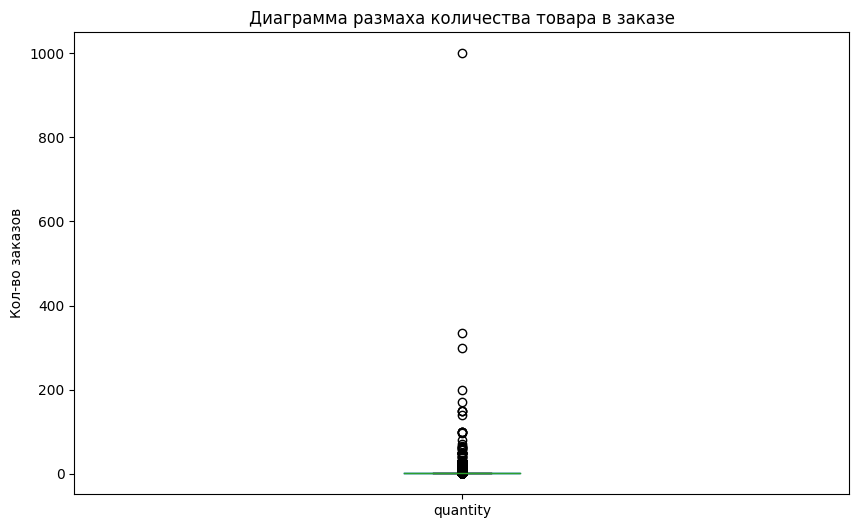

In [32]:
plt.figure(figsize=(10, 6))

df.boxplot('quantity', 
           grid= False)

plt.title('Диаграмма размаха количества товара в заказе')
plt.xlabel('') 
plt.ylabel('Кол-во заказов')
plt.show()

В данных есть значительные выбросы. 

Приблизим график и посмотрим на распределение ближе к медианным значениям. 

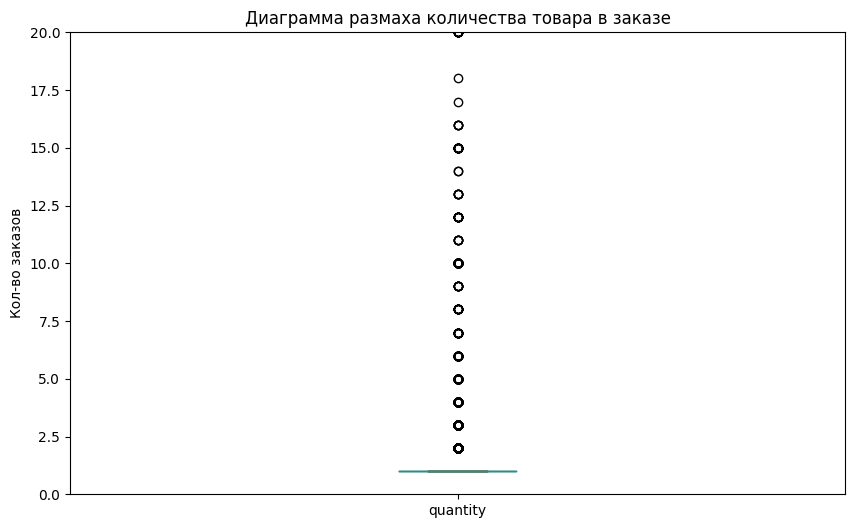

In [33]:
plt.figure(figsize=(10, 6))

df.boxplot('quantity', 
           grid= False)

plt.ylim(0,20)
plt.title('Диаграмма размаха количества товара в заказе')
plt.xlabel('') 
plt.ylabel('Кол-во заказов')
plt.show()

На графике мы видим только линию, а не "ящик с усами". Это связано с тем, что медианное значение равно 3-ему квартилю или 75-ому перцентилю.

Для определения границы аномальных значений посмотрим на значения 95 и 99 перцентилей.

In [34]:
print(np.percentile(df['quantity'], [95, 99]))

[ 6.   25.57]


Не более 5% количество товара в заказе больше 6 штук и не более 1%  количество товара больше 26. Так как у нас розница, а не оптовый магазин, то установим границу аномальных значений на уровне 99 перцентили.  

Посмотрим какие товары заказывали в таком количестве. 

In [35]:
df.loc[df['quantity'] > 25, ['product','quantity']].sort_values(by='quantity', ascending=False)

,product,quantity
5456,"вантуз с деревянной ручкой d14 см красный, bur...",1000
5071,вешалки мягкие для деликатных вещей 3 шт шоколад,334
3961,муляж яблоко 9 см красное,300
1158,"ручка-скоба рс-100 белая *трибатрон*, 1108035",200
568,муляж яблоко 9 см красное,170
211,"крепеж для пружины дверной, 1107055",150
212,пружина дверная 240 мм оцинкованная (д-19 мм) ...,150
2431,плечики пластмассовые размер 52 - 54 тула 1205158,150
586,муляж яблоко 9 см красное,140
6707,"шпингалет 80 мм белый с пружиной, 1102188",100


In [36]:
print('Кол-во выбросов:', df[df['quantity'] > 25].shape[0])
print('Относительные потери:', '{0:.1%}'.format(df[df['quantity'] > 25].shape[0]/df.shape[0]))

Кол-во выбросов: 56
Относительные потери: 1.0%


In [37]:
# удалим выбросы 

df = df[df['quantity'] <= 25]

Построим диаграмму размаха по цене товара.

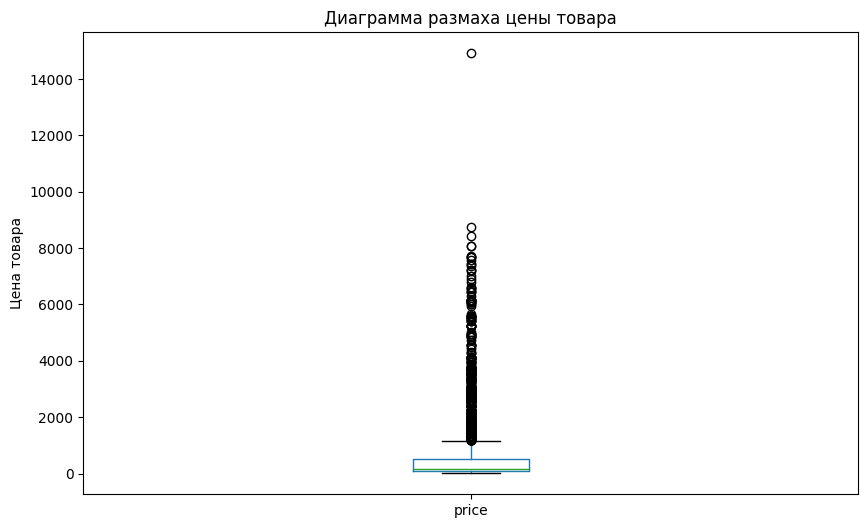

In [38]:
plt.figure(figsize=(10, 6))
df.boxplot('price', 
           grid= False)

plt.title('Диаграмма размаха цены товара')
plt.xlabel('') 
plt.ylabel('Цена товара')
plt.show()

Приблизим график и посмотрим на распределение ближе к медианным значениям. 

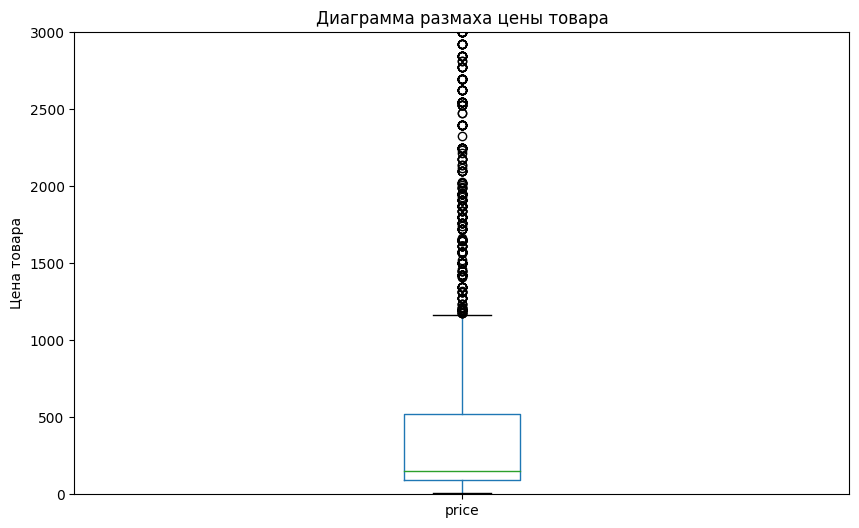

In [39]:
plt.figure(figsize=(10, 6))
df.boxplot('price', 
           grid= False)

plt.ylim(0,3000)
plt.title('Диаграмма размаха цены товара')
plt.xlabel('') 
plt.ylabel('Цена товара')
plt.show()

Узнаем значения 95 и 99 перцентилей.

In [40]:
print(np.percentile(df['price'], [95, 99]))

[2399.   5253.94]


Не более 5% цена товара выше 2399 рублей и не более 1% выше 5254.

Посмотрим какие товары продаются по самой высокой цене. 

In [41]:
df.loc[df['price'] > 5254, ['product','price']].sort_values(by='price', ascending=False)

,product,price
5992,сушилка уличная leifheit 85210 linomatic v 400...,14917.0
2697,сумка-тележка хозяйственная andersen royal sho...,8737.0
1981,сумка-тележка хозяйственная andersen alu star ...,8437.0
7436,сумка-тележка хозяйственная rolser mnb019 rojo...,8077.0
2997,сумка-тележка хозяйственная rolser mnb019 rojo...,8077.0
6629,стремянка 7 ступенчатая hailo 8040-707 xxl 13 ...,7724.0
7190,сумка-тележка хозяйственная rolser imx006 bass...,7679.0
5994,сумка-тележка хозяйственная rolser mnb017 fucs...,7679.0
2339,сумка-тележка хозяйственная rolser imx006 bass...,7679.0
654,сумка-тележка хозяйственная rolser mou041 malv...,7597.0


Считать выбросамм высокие цены на товары не будем. Сохраним данные.

## Добавление новых столбцов

In [42]:
pd.options.mode.chained_assignment = None

In [43]:
# добавим столбец с суммой заказа

df['order_price'] = df['quantity'] * df['price']

In [44]:
# добавим столбцы с годом, месяцем, кварталом и днем транзакций 

df['year'] = df['date'].dt.year
df['quarter'] = df['date'].dt.quarter
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day

In [45]:
df.head()

,date,customer_id,order_id,product,quantity,price,order_price,year,quarter,month,day
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке алое вера, d12, h30",1,142.0,142.0,2018,4,10,1
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке кофе арабика, d12,...",1,194.0,194.0,2018,4,10,1
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,радермахера d-12 см h-20 см,1,112.0,112.0,2018,4,10,1
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,хризолидокарпус лутесценс d-9 см,1,179.0,179.0,2018,4,10,1
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,циперус зумула d-12 см h-25 см,1,112.0,112.0,2018,4,10,1


## Исследовательский анализ данных

Посмотрим как данные распределяются по годам.

In [46]:
df['year'].value_counts()

2019    4022
2018    1197
2020     269
Name: year, dtype: int64

Построим диаграмму распределения данных по годам и месяцам.

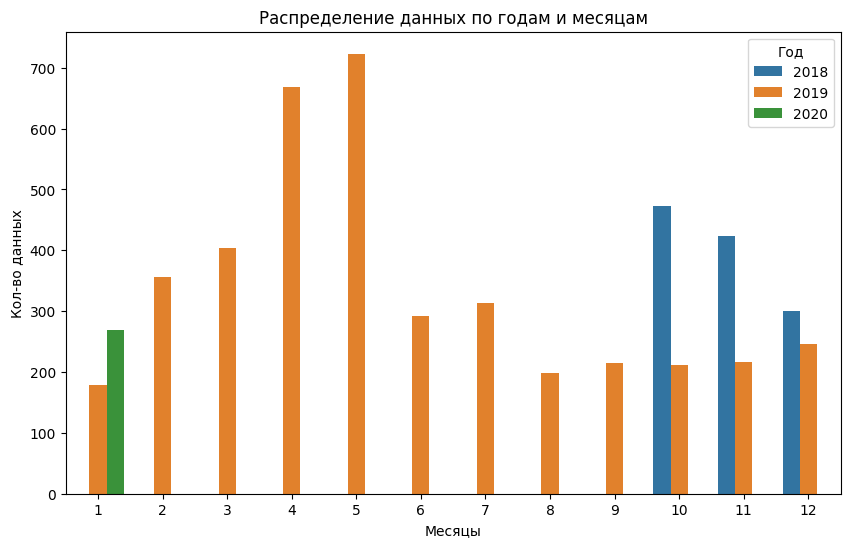

In [47]:
plt.figure(figsize=(10, 6))

df_count_month = df.groupby(['year','month'])['month'].count().reset_index(name='count')
sns.barplot(x=df_count_month['month'], y=df_count_month['count'], hue=df_count_month['year'])

plt.title('Распределение данных по годам и месяцам')
plt.xlabel('Месяцы') 
plt.ylabel('Кол-во данных')
plt.legend(title='Год')
plt.show()

За 2018 год информация представлена только за 4 квартал. За 2019 за весь год, а за 2020 только за январь.  
Для дальнейшего анализа сохраним все данные.

### ABC-анализ

Узнаем количество уникальных названий товаров.

In [48]:
df['product'].nunique()

2314

Получилось достаточно больше количество наименований. Для анализа попробуем распределить товары по группам.

In [49]:
# выделим из названий товаров 2 первых слова 

df['product_name'] = df['product'].apply(lambda x: x.split()[0:2])
list(df['product_name'].head(10))

[['комнатное', 'растение'],
 ['комнатное', 'растение'],
 ['радермахера', 'd-12'],
 ['хризолидокарпус', 'лутесценс'],
 ['циперус', 'зумула'],
 ['шеффлера', 'лузеана'],
 ['юкка', 'нитчатая'],
 ['настенная', 'сушилка'],
 ['таз', 'пластмассовый'],
 ['чехол', 'для']]

In [50]:
# удалим второе слово, если оно содержит менее 4 букв 

df['product_name'] = df['product_name'].apply(lambda x: x if len(x[1])>3 else [x[0]])
list(df['product_name'].head(10))

[['комнатное', 'растение'],
 ['комнатное', 'растение'],
 ['радермахера', 'd-12'],
 ['хризолидокарпус', 'лутесценс'],
 ['циперус', 'зумула'],
 ['шеффлера', 'лузеана'],
 ['юкка', 'нитчатая'],
 ['настенная', 'сушилка'],
 ['таз', 'пластмассовый'],
 ['чехол']]

In [51]:
# соединим слова из списков в строку
# оставим в названиях только слова состоящие из букв кириллицы  

df['product_name'] = df['product_name'].apply(lambda x: ' '.join(re.findall('[А-Яа-яЁё]+', str(x))))

Узнаем количество наименований в группах.

In [52]:
df['product_name'].nunique()

800

Создадим словарь, и разделим наименования товаров на 8 категорий.

In [53]:
dict_product = {
    
    'Декор и интерьер': ['муляж', 'искусственный цветок', 'цветок искусственный', 'коврик', 'ковер', 'штора', 
                         'искусственная композиция', 'кашпо', 'декоративная композиция', 'крючок', 'покрытие', 
                         'плед', 'покрывало', 'искусственная лиана', 'ковёр', 'наматрасник','одеяло', 'подушка', 
                         'комплект постельного', 'постельное', 'ваза','наволочка', 'простыня', 'набор ковров', 
                         'фоторамка', 'наматрацник', 'пододеяльник'],  
    
    'Мебель': ['подставка','полки', 'лестница', 'стремянки', 'стремянка', 'ящик почтовый', 'комод','стеллаж', 'полка', 
               'светильник', 'обувница', 'этажерка', 'складной детский пуф', 'пылесос'],
    
    'Товары для стирки и глажки': ['сушилка', 'доска гладильная', 'гладильная доска', 'подрукавник', 
                                   'рукав для гладильной доски', 'сетка для глажения', 'кондиционер', 'набор прищепок', 
                                   'прищепки', 'сетка для стирки', 'гель для стирки', 'утюг'], 
     
    'Товары для дома': ['комплект махровых', 'подголовник', 'махровое полотенце', 'сиденье', 'щетка', 'таз', 'корыто', 
                        'ведро', 'средство', 'швабра', 'насадка', 'ерш', 'ёрш', 'мыло', 'подголовник', 'зубная паста', 
                        'паста зубная', 'дозатор', 'окномойка', 'полотенце','стяжка оконная', 'тряпкодержатель', 
                        'пробка для ванны', 'халат', 'скребок', 'увлажняющая маска','вантуз','тряпка', 'пена для ванн',
                        'мыльница', 'ткань', 'губка', 'ролик для чистки одежды', 'сменный блок', 'отжим для ведра', 
                        'антинакипин', 'ванна', 'чистящий крем', 'фен дорожный','сковорода', 'крышка для сковороды', 'тарелка', 
                        'ложка', 'вилка', 'нож', 'кружка', 'чайник', 'салатник', 'банка', 'кувшин', 'термос', 'терка', 'стакан', 
                        'набор фужеров', 'чайный набор', 'овощеварка', 'лоток', 'разделочная доска', 'миска', 'просеиватель', 
                        'веник', 'хлебница', 'блюдце','блюдо', 'урна', 'емкость', 'кастрюля', 'набор бокалов', 'форма', 'сито', 
                        'рыбочистка', 'вакуумный пакет', 'кисточка силиконовая', 'соковыжималка', 'сахарница', 'толкушка', 
                        'доска разделочная', 'бидон', 'масленка', 'совок', 'пьезозажигалка', 'отделитель косточек', 
                        'набор форм для кексов', 'миксер', 'соковарка', 'рассекатель пламени', 'набор посуды', 'бульонница',
                        'бальзам для мытья посуды', 'кипятильник', 'половник', 'мантоварка', 'электроштопор', 
                        'набор махровых салфеток', 'котел алюминиевый', 'картофелемялка', 'тортница', 'венчик', 'овощечистка',
                        'набор столовых', 'набор кружек', 'сметка', 'защитная соль', 'пресс для чеснока', 
                        'концентрат для мытья посуды', 'скалка', 'антижир', 'набор кухонных', 'орехоколка', 'ковш', 
                        'противень прямоугольный', 'салфетка', 'скатерть', 'весы'],
    
    'Товары для хранения вещей': ['корзина', 'чехол', 'контейнер', 'набор вешалок', 'вешалка', 'плечики', 'вешалки', 'ящик', 
                                  'коробка', 'бак', 'мешок', 'корзинка', 'стяжки для чехла'],
    
    'Сумки и тележки': ['сумка', 'тележка'],
    
    'Инструменты': ['бензин', 'термометр', 'фал капроновый', 'линейка', 'штангенциркуль', 'холодная сварка', 
                    'шпагат полипропиленовый','крышка оцинкованная', 'кольца', 'нетканые салфетки', 'сверло фреза', 
                    'петля рояльная', 'лопатка','ключница', 'сверло-фреза', 'петля-стрела', 'измерительный угольник', 
                    'сверло', 'крепеж', 'паста', 'набор инструментов', 'петля приварная', 'набор прецизионных напильников', 
                    'шнур хозяйственный', 'основание для пробки электрический', 'шило', 'ручка-скоба',
                    'многофункциональный инструмент', 'фиксатор-шар хром', 'решетка вентиляционная', 'набор сверел', 
                    'шнур резиновый', 'карниз', 'штанга', 'перчатки'],
    
    'Растения': ['растение','d12', 'd-', 'объем 05 л', 'объем 0,5 л','объем 1 л', 'd12','диам. 12 см', 'р-9', 'd9',
                 'зональная','рассада','роза','пеларгония', 'петуния', 'томата', 'томат','флокс', 'цикламен', 'кофр', 'базилик', 
                 'капуста', 'настурция', 'вербейник', 'незабудка', 'антуриум', 'укроп', 'гипсофила', 'примула', 'ранункулус', 
                 'петрушка корневая', 'лавр', 'клен', 'клубника', 'петрушка', 'гвоздика', 'калла', 'космея', 'хризантема', 
                 'виноград', 'алиссум', 'бархатцы', 'рукола', 'тюльпан', 'календула', 'кипарисовик', 'сельдерей', 'огурец',
                 'змееголовник', 'цинерария', 'тимьян', 'гиностемма', 'цинния', 'гортензия', 'осина', 'фуксия', 'морковь детская',
                 'любисток', 'шалфей', 'рудбекия', 'лаватера', 'кодонанта', 'ель', 'валериана', 'вигна', 'дендробиум',
                 'гайлардия', 'горох амброзия', 'пуансеттия', 'кореопсис', 'земляника барон', 'георгина', 'смолевка', 'годеция',
                 'кориандр', 'маттиола', 'лапчатка', 'эшшольция', 'хоста микс']

} 

In [54]:
# функция выводит ключ словаря, если столбец product содержит значение словаря

def product(row):
    for key, values in dict_product.items(): 
        for v in values:
            if re.search(v, row['product']):
                return key

In [55]:
# применим функцию

df['product_group'] = df.apply(product, axis=1)
df

,date,customer_id,order_id,product,quantity,price,order_price,year,quarter,month,day,product_name,product_group
0,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке алое вера, d12, h30",1,142.0,142.0,2018,4,10,1,комнатное растение,Растения
1,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке кофе арабика, d12,...",1,194.0,194.0,2018,4,10,1,комнатное растение,Растения
2,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,радермахера d-12 см h-20 см,1,112.0,112.0,2018,4,10,1,радермахера,Растения
3,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,хризолидокарпус лутесценс d-9 см,1,179.0,179.0,2018,4,10,1,хризолидокарпус лутесценс,Растения
4,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,циперус зумула d-12 см h-25 см,1,112.0,112.0,2018,4,10,1,циперус зумула,Растения
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7469,2020-01-30 21:00:00,63208953-a8e4-4f77-9b47-3a46e7b72eee,104002,томата (помидор) черниченский черри № 116 сорт...,2,38.0,76.0,2020,1,1,30,томата помидор,Растения
7470,2020-01-30 22:00:00,d99d25f1-4017-4fcd-8d29-c580cc695a1a,107336,дендробиум санок анна грин 1 ствол d-12 см,1,869.0,869.0,2020,1,1,30,дендробиум санок,Растения
7471,2020-01-31 02:00:00,2c9bd08d-8c55-4e7a-9bfb-8c56ba42c6d6,106336,подставка для обуви резиновая attribute 80x40 ...,1,354.0,354.0,2020,1,1,31,подставка,Мебель
7472,2020-01-31 12:00:00,cdd17932-623e-415f-a577-3b31312fd0e2,102002,тагетис крупноцветковый рассада однолетних цве...,1,128.0,128.0,2020,1,1,31,тагетис крупноцветковый,Растения


Посмотрим как распределяются данные по категориям товаров.

In [56]:
df['product_group'].value_counts(dropna=False)

Растения                      2700
Товары для дома                770
Декор и интерьер               631
Товары для стирки и глажки     480
Сумки и тележки                368
Товары для хранения вещей      330
Мебель                         118
Инструменты                     91
Name: product_group, dtype: int64

Наибольшее разнообразие наименований в категории растения. 
Наименований без категорий (NaN) нет. 

Анализ товарного ассортимента будет проводиться с помощью параллельного подхода по 2 критериям: количество продаж и оборот.
    
Определим процентное соотношение для разделения товаров на категории как: `80-15-5`

In [57]:
# функция для разделения групп товаров на подкатегории ABC 
# до 70% категория A, от 70 до 95 катгория B, более 95 категория C

def category(row):
    if row['cumulative_per'] <= 80:
        return 'A'
    elif 80 < row['cumulative_per'] <= 95:
        return 'B'
    else:
        return 'C'

#### Подкатегории ABC по количеству продаж 

In [58]:
# сгруппируем данные по группе товара и просуммируем кол-во продаж

df_pivot_prodg = df.pivot_table(index='product_group', 
                                values='quantity', 
                                aggfunc='sum').reset_index().sort_values(by='quantity', ascending=False)

# посчитаем процент каждой группы от общего кол-ва продаж

df_pivot_prodg['per'] = (df_pivot_prodg['quantity'] / sum(df_pivot_prodg['quantity']) *100).round(2)

# посчитаем кумулятивные значения процента 

df_pivot_prodg['cumulative_per'] = df_pivot_prodg['per'].cumsum().round(0)

df_pivot_prodg

,product_group,quantity,per,cumulative_per
3,Растения,3890,41.16,41.0
0,Декор и интерьер,1870,19.79,61.0
5,Товары для дома,1801,19.06,80.0
7,Товары для хранения вещей,634,6.71,87.0
6,Товары для стирки и глажки,541,5.72,92.0
4,Сумки и тележки,376,3.98,96.0
1,Инструменты,204,2.16,99.0
2,Мебель,134,1.42,100.0


In [59]:
# применим функцию для разделения групп товаров на подкатегории ABC

df_pivot_prodg['category_quantity'] = df_pivot_prodg.apply(category, axis=1)
df_pivot_prodg

,product_group,quantity,per,cumulative_per,category_quantity
3,Растения,3890,41.16,41.0,A
0,Декор и интерьер,1870,19.79,61.0,A
5,Товары для дома,1801,19.06,80.0,A
7,Товары для хранения вещей,634,6.71,87.0,B
6,Товары для стирки и глажки,541,5.72,92.0,B
4,Сумки и тележки,376,3.98,96.0,C
1,Инструменты,204,2.16,99.0,C
2,Мебель,134,1.42,100.0,C


Построим диаграмму распределения групп товаров по количеству продаж.

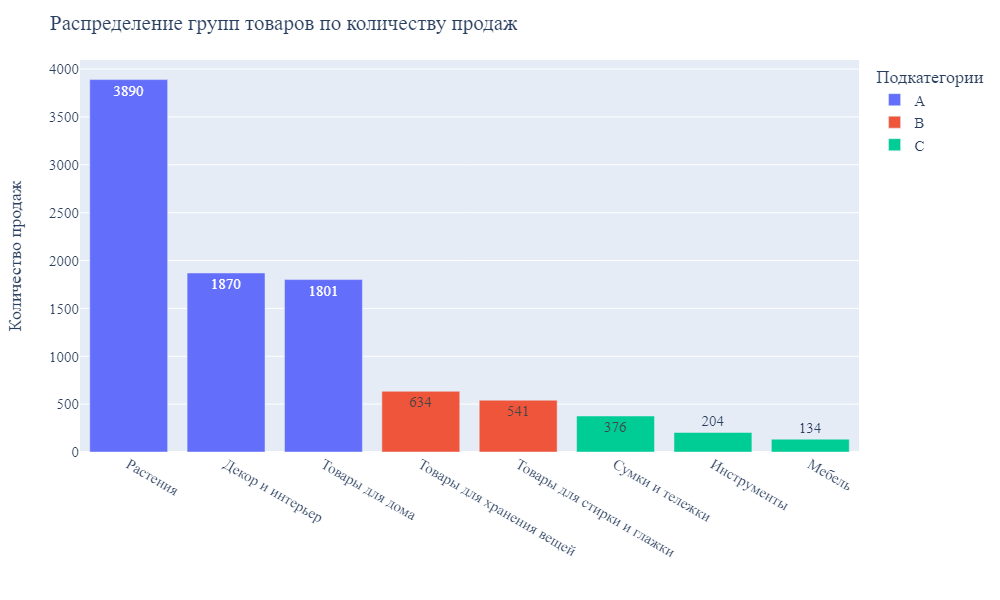

In [60]:
fig = px.bar(df_pivot_prodg.sort_values(by='quantity', ascending=False),
             x='product_group',
             y='quantity',
             text='quantity',
             color='category_quantity'
             #template='none'
            ) 

fig.update_layout(title ='Распределение групп товаров по количеству продаж',
                  xaxis_title='',
                  yaxis_title='Количество продаж',
                  font_size=15,
                  font_family='Helvetica Neue',
                  legend_title='Подкатегории'
                  #showlegend=False
                  )

fig.show()

По количеству продаж в подкатегории А попали: растения, декор и интерьер, товары для дома.

#### Подкатегории ABC по обороту

In [61]:
# сгруппируем данные по группе товара и просуммируем сумма заказа (оборот)

df_pivot_price = df.pivot_table(index='product_group', 
                                values='order_price', 
                                aggfunc='sum').reset_index().round(2).sort_values(by='order_price', ascending=False)


df_pivot_price['per'] = (df_pivot_price['order_price'] / sum(df_pivot_price['order_price']) *100).round(2)
df_pivot_price['cumulative_per'] = df_pivot_price['per'].cumsum().round(0)

df_pivot_price

,product_group,order_price,per,cumulative_per
4,Сумки и тележки,789323.25,21.98,22.0
6,Товары для стирки и глажки,654228.00,18.22,40.0
5,Товары для дома,625095.83,17.41,58.0
3,Растения,532119.33,14.82,72.0
0,Декор и интерьер,467100.83,13.01,85.0
2,Мебель,237566.00,6.62,92.0
7,Товары для хранения вещей,237396.17,6.61,99.0
1,Инструменты,47988.00,1.34,100.0


In [62]:
# применим функцию и для разделения на подкатегории ABC

df_pivot_price['category_order_price'] = df_pivot_price.apply(category, axis=1)
df_pivot_price

,product_group,order_price,per,cumulative_per,category_order_price
4,Сумки и тележки,789323.25,21.98,22.0,A
6,Товары для стирки и глажки,654228.00,18.22,40.0,A
5,Товары для дома,625095.83,17.41,58.0,A
3,Растения,532119.33,14.82,72.0,A
0,Декор и интерьер,467100.83,13.01,85.0,B
2,Мебель,237566.00,6.62,92.0,B
7,Товары для хранения вещей,237396.17,6.61,99.0,C
1,Инструменты,47988.00,1.34,100.0,C


Построим диаграмму топ-10 товаров по обороту.

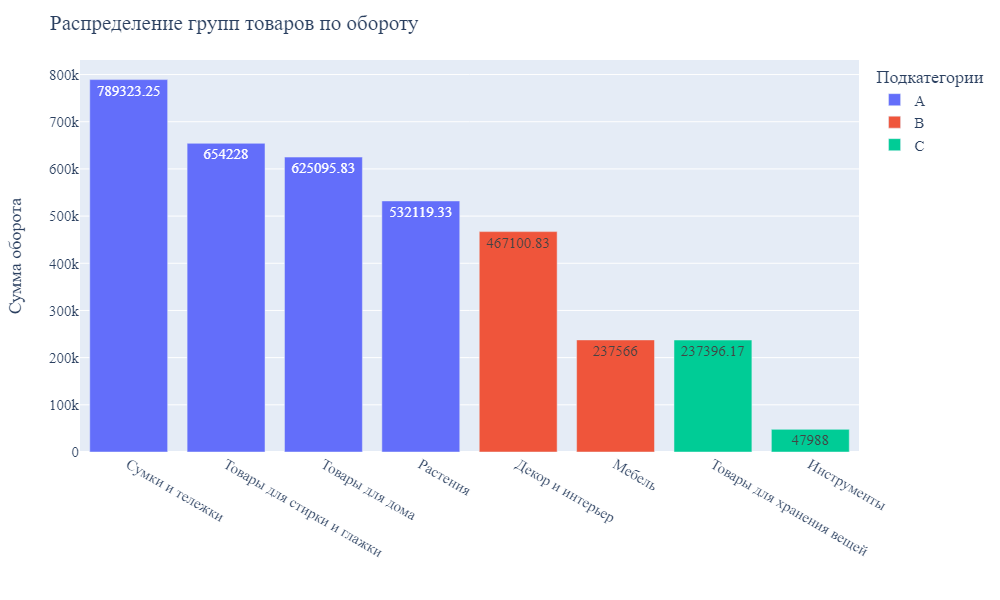

In [63]:
fig = px.bar(df_pivot_price.sort_values(by='order_price', ascending=False),
             x='product_group',
             y='order_price',
             text='order_price',
             color='category_order_price'
             #template='none'
            ) 

fig.update_layout(title ='Распределение групп товаров по обороту',
                  xaxis_title='',
                  yaxis_title='Сумма оборота',
                  font_size=15,
                  font_family='Helvetica Neue',
                  legend_title='Подкатегории'
                  )

fig.show()

По сумме оборота лидеры в категориях сменились. В подкатегорию А входят: сумки и тележки, товары для стирки и глажки, товары для дома и растения. 

#### Категории товаров ABC-анализа

In [64]:
# объединим названия подкатегорий по кол-ву продаж с основной таблицей

df = df.merge(df_pivot_prodg[['product_group', 'category_quantity']], 
              how='left', 
              left_on='product_group', 
              right_on='product_group')

In [65]:
# объединим названия подкатегорий по обороту с основной таблицей

df = df.merge(df_pivot_price[['product_group', 'category_order_price']], 
              how='left', 
              left_on='product_group', 
              right_on='product_group')

In [66]:
df.head()

,date,customer_id,order_id,product,quantity,price,order_price,year,quarter,month,day,product_name,product_group,category_quantity,category_order_price
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке алое вера, d12, h30",1,142.0,142.0,2018,4,10,1,комнатное растение,Растения,A,A
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке кофе арабика, d12,...",1,194.0,194.0,2018,4,10,1,комнатное растение,Растения,A,A
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,радермахера d-12 см h-20 см,1,112.0,112.0,2018,4,10,1,радермахера,Растения,A,A
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,хризолидокарпус лутесценс d-9 см,1,179.0,179.0,2018,4,10,1,хризолидокарпус лутесценс,Растения,A,A
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,циперус зумула d-12 см h-25 см,1,112.0,112.0,2018,4,10,1,циперус зумула,Растения,A,A


In [67]:
# соединим названия подкатегорий по двум критериям в название категорий

df['category'] = df['category_quantity']+df['category_order_price']

In [68]:
df.head()

,date,customer_id,order_id,product,quantity,price,order_price,year,quarter,month,day,product_name,product_group,category_quantity,category_order_price,category
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке алое вера, d12, h30",1,142.0,142.0,2018,4,10,1,комнатное растение,Растения,A,A,AA
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке кофе арабика, d12,...",1,194.0,194.0,2018,4,10,1,комнатное растение,Растения,A,A,AA
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,радермахера d-12 см h-20 см,1,112.0,112.0,2018,4,10,1,радермахера,Растения,A,A,AA
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,хризолидокарпус лутесценс d-9 см,1,179.0,179.0,2018,4,10,1,хризолидокарпус лутесценс,Растения,A,A,AA
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,циперус зумула d-12 см h-25 см,1,112.0,112.0,2018,4,10,1,циперус зумула,Растения,A,A,AA


Сгруппируем данные и посмотрим на категории и какие группы товаров будут к ним относится.

In [69]:
cat_product_group = df.groupby(['category','product_group'])[['quantity','order_price']].sum().reset_index().round()

cat_product_group['cat'] = cat_product_group['category'].apply(lambda x: 'Дополнительный' if x in ['BC', 'CB', 'CC'] else 'Основной')                                                         
        
cat_product_group

,category,product_group,quantity,order_price,cat
0,AA,Растения,3890,532119.0,Основной
1,AA,Товары для дома,1801,625096.0,Основной
2,AB,Декор и интерьер,1870,467101.0,Основной
3,BA,Товары для стирки и глажки,541,654228.0,Основной
4,BC,Товары для хранения вещей,634,237396.0,Дополнительный
5,CA,Сумки и тележки,376,789323.0,Основной
6,CB,Мебель,134,237566.0,Дополнительный
7,CC,Инструменты,204,47988.0,Дополнительный


Поделим товар на основную и дополнительную категорию. К основному ассортименту будут относиться товары, которые вошли или по количеству товаров или по обороту в категорию А. К дополнительным - все остальные. При закупках приоритет следует отдавать основному товару, т.к. из него состоит главный доход интернет-магазина. 

АВС-анализ позволил нам распределить ассортимент товаров для дома и быта на 8 категорий. 

- категория АА — товары-лидеры. Лучше всего продаются и приносят наибольшую сумму по обороту. Следует тщательно контролировать уровень закупок, т.к. товары постоянно должны быть в наличии;
- категория СС — товары-аутсайдеры, плохо продаются и приносят минимальную сумму от продаж. Следует провести детальный анализ категории и возможно предпринять выведение самых низкоэффективных товаров из ассортимента;
- остальные категории — товары-середнячки. Допустим средний уровень управления закупками.

Дополнительно обратим внимание на следующие категории товаров из середнячков:
- категория BA — товары, которые приносят значительную сумму по обороту, но продаются в меньше количестве, чем группа AA. При проведении промоакций товары данной категории принесут максимальную эффективность;
- категория CA — товары с высоким прайсом, приносят значительную сумму выручки от редких продаж. Закупки рекомендуется организовывать с учетом сезонности продаж или по факту продажи.

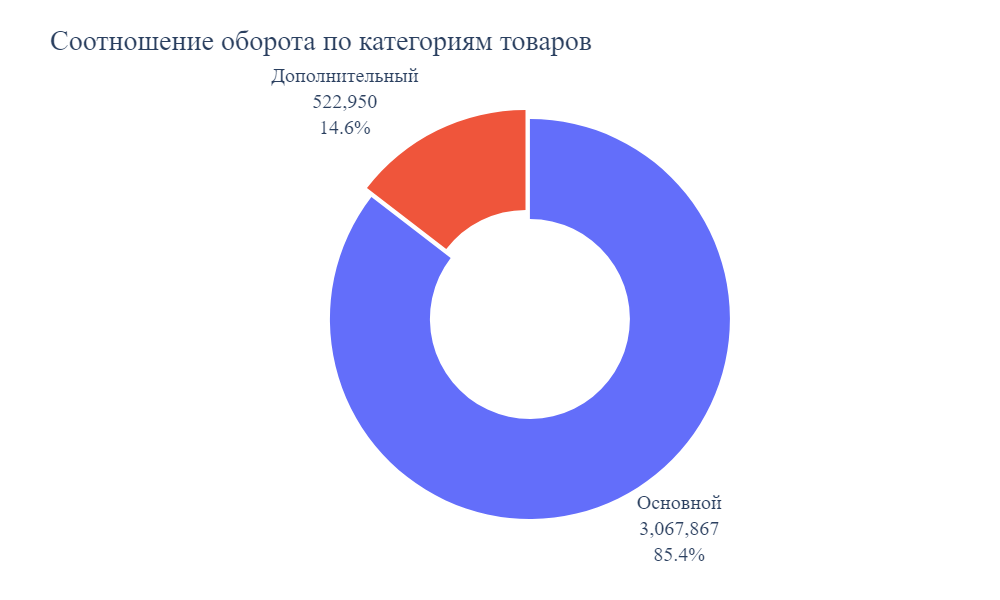

In [70]:
fig = go.Figure(data=[go.Pie(labels=cat_product_group['cat'], 
                             values=cat_product_group['order_price'],
                             pull = [0.05, 0],
                             hole=0.5)]
               )

fig.update_traces(textposition='outside', 
                  textinfo='percent+label+value')

fig.update_layout(showlegend=False,
                  title ='Соотношение оборота по категориям товаров',
                  font_size=20,
                  font_family='Helvetica Neue'
                 )

fig.show() 

In [71]:
# функция для разделения категорий товаров на лидеров, середнячков и аутсайдеры

def category_name(row):
    if row['category'] == 'AA':
        return 'Товары-лидеры'
    elif row['category'] == 'CC':
        return 'Товары-аутсайдеры'
    else:
        return 'Товары-середнячки'

In [72]:
# применим функцию

df['category_name'] = df.apply(category_name, axis=1)

In [73]:
df.head()

,date,customer_id,order_id,product,quantity,price,order_price,year,quarter,month,day,product_name,product_group,category_quantity,category_order_price,category,category_name
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке алое вера, d12, h30",1,142.0,142.0,2018,4,10,1,комнатное растение,Растения,A,A,AA,Товары-лидеры
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке кофе арабика, d12,...",1,194.0,194.0,2018,4,10,1,комнатное растение,Растения,A,A,AA,Товары-лидеры
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,радермахера d-12 см h-20 см,1,112.0,112.0,2018,4,10,1,радермахера,Растения,A,A,AA,Товары-лидеры
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,хризолидокарпус лутесценс d-9 см,1,179.0,179.0,2018,4,10,1,хризолидокарпус лутесценс,Растения,A,A,AA,Товары-лидеры
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,циперус зумула d-12 см h-25 см,1,112.0,112.0,2018,4,10,1,циперус зумула,Растения,A,A,AA,Товары-лидеры


Посмотрим на полученное соотношение.

In [74]:
df_pie = df.pivot_table(index='category_name', 
               values='product_group', 
               aggfunc='nunique').reset_index().sort_values(by='product_group', ascending=False)
df_pie

,category_name,product_group
2,Товары-середнячки,5
1,Товары-лидеры,2
0,Товары-аутсайдеры,1


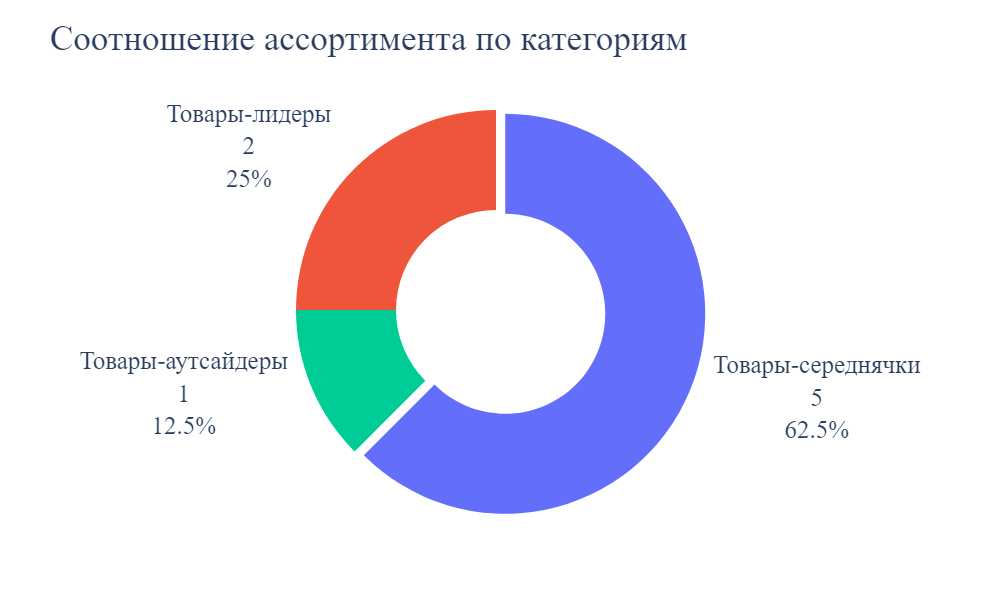

In [75]:
fig = go.Figure(data=[go.Pie(labels=df_pie['category_name'], 
                             values=df_pie['product_group'],
                             pull = [0.05, 0],
                             hole=0.5)]
               )

fig.update_traces(textposition='outside', 
                  textinfo='percent+label+value')

fig.update_layout(showlegend=False,
                  title ='Соотношение ассортимента по категориям',
                  font_size=25,
                  font_family='Helvetica Neue'
                 )

fig.show() 

#### Сезонность продаж

Так как у нас полные данные только за 2019 год, то сезонность продаж по категориям товаров будем смотреть именно по нему.

In [76]:
# отфильруем 2019 год, сгруппируем данные по месяцу и названию категории, просуммируем кол-во продаж и оборот 

df_month_category_name = df.query('year == 2019').pivot_table(index=['month', 'category_name'], 
                                                              values=['quantity', 'order_price'],
                                                              aggfunc='sum').reset_index().round(2)
df_month_category_name.head()

,month,category_name,order_price,quantity
0,1,Товары-аутсайдеры,986.0,5
1,1,Товары-лидеры,57463.0,184
2,1,Товары-середнячки,102692.0,169
3,2,Товары-аутсайдеры,6764.0,44
4,2,Товары-лидеры,85489.0,378


Построим диаграмму сезонности по количеству продаж.

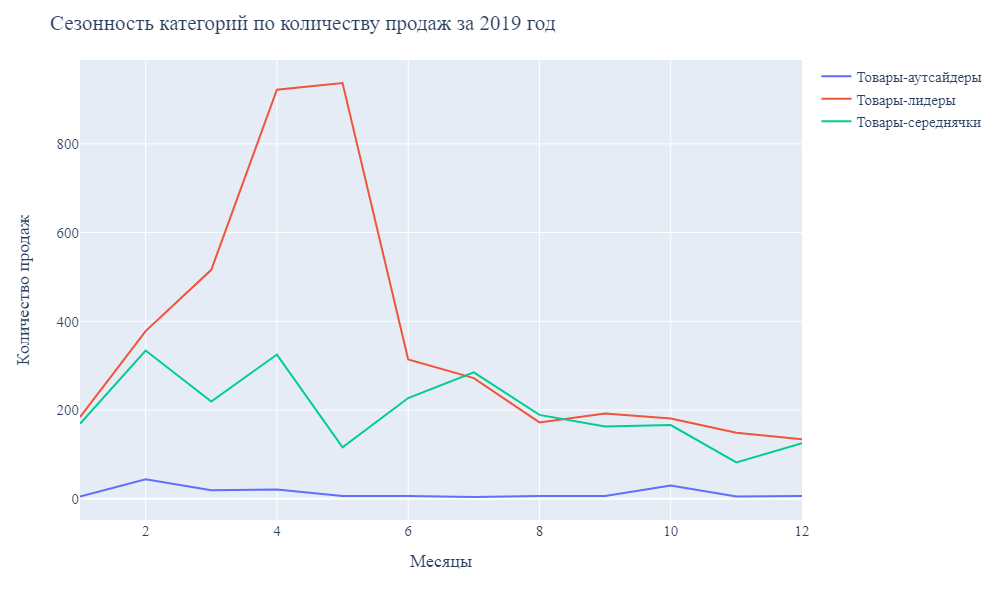

In [77]:
fig = px.line(x=df_month_category_name['month'], 
              y=df_month_category_name['quantity'], 
              color=df_month_category_name['category_name'])

fig.update_layout(title ='Сезонность категорий по количеству продаж за 2019 год',
                  xaxis_title='Месяцы',
                  yaxis_title='Количество продаж',
                  font_size=15,
                  font_family='Helvetica Neue',
                  legend_title=''
                  )

fig.show()

Товары-лидеры покупают в большем количестве, чем товары-середнячки. Если посмотреть на динамику, то видно, что наилучшие продажи товаров-лидеров приходятся на апрель и май, это связано, скорее всего, с дачным сезоном. Товары-середнячки показывают достаточно стабильную динамику в течение года, однако, в мае количество их продаж ниже обычного.

Построим диаграмму сезонности по обороту.

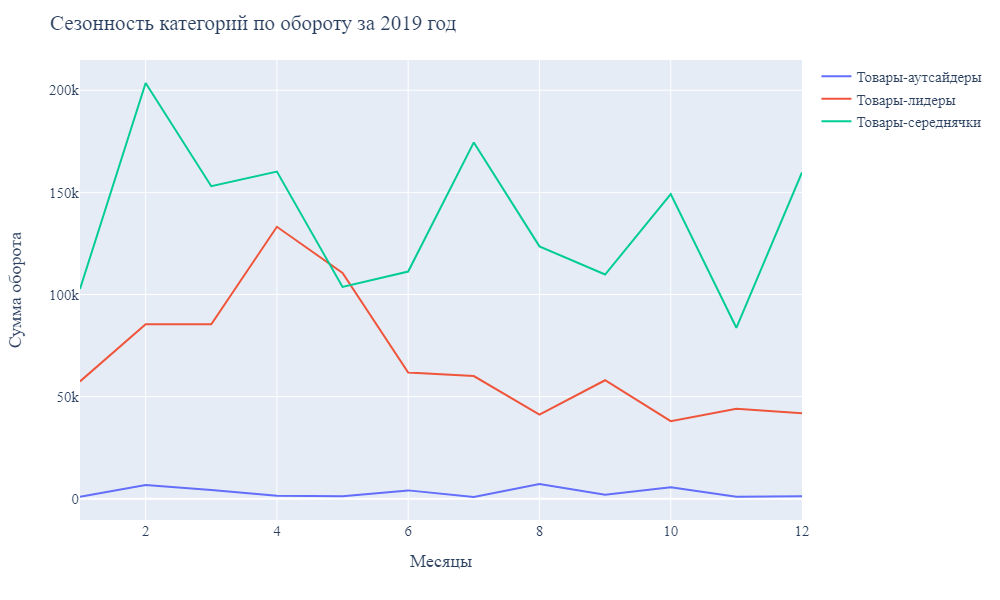

In [78]:
fig = px.line(x=df_month_category_name['month'], 
              y=df_month_category_name['order_price'], 
              color=df_month_category_name['category_name'])

fig.update_layout(title ='Сезонность категорий по обороту за 2019 год',
                  xaxis_title='Месяцы',
                  yaxis_title='Сумма оборота',
                  font_size=15,
                  font_family='Helvetica Neue',
                  legend_title=''
                  )

fig.show()

По обороту мы видим необычный результат. Товары-середнячки приносят в течение года большую сумму выручки, чем товары-лидеры. Динамика в течение года коррелирует с динамикой количества продаж. 

## Проверка гипотез

На основе полученных результатов ABC-анализа сформулируем две гипотезы и попробуем их подтвердить статистически.

In [79]:
# узнаем кол-во данных в выборках

print((df[(df['category_name']=='Товары-лидеры') & (df['year']==2019)]['order_price']).count())
print((df[(df['category_name']=='Товары-середнячки') & (df['year']==2019)]['order_price']).count())

2703
1263


Сформулируем гипотезы.  
Нулевая гипотеза: в среднем сумма оборота товаров-лидеров не отличается от суммы оборота товаров-середнячков.  
Альтернативная гипотеза: в среднем сумма оборота товаров-лидеров меньше суммы оборота товаров-середнячков.  

Для получения результатов будем использовать метод проверки односторонних гипотез.

In [80]:
sample1 = df[(df['category_name']=='Товары-лидеры') & (df['year']==2019)]['order_price']

sample2 = df[(df['category_name']=='Товары-середнячки') & (df['year']==2019)]['order_price'].mean()

alpha = .05 # уровень статистической значимости

results = st.ttest_1samp(
    sample1, 
    sample2)

# тест односторонний: p-value будет в два раза меньше
print('p-значение:', results.pvalue / 2)

# тест односторонний влево:
# отвергаем гипотезу только тогда, когда выборочное среднее значимо меньше предполагаемого значения
if (results.pvalue / 2 < alpha) and (sample1.mean() < sample2):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не отвергаем нулевую гипотезу") 

p-значение: 0.0
Отвергаем нулевую гипотезу


Результат показал, что статистически в среднем сумма оборота товаров-лидеров, действительно, значимо меньше суммы оборота товаров-середнячков. Подобную картину мы наблюдали на диаграмме сезонности.

Проверим гипотезы по количеству продаж.

Сформулируем гипотезы.  
Нулевая гипотеза: в среднем товары-лидеры покупают в таком же количестве, как и товаров-середнячки.  
Альтернативная гипотеза: в среднем товары-лидеры покупают в большем количестве, чем товары-середнячки.

In [81]:
sample1 = df[(df['category_name']=='Товары-лидеры') & (df['year']==2019)]['quantity']

sample2 = df[(df['category_name']=='Товары-середнячки') & (df['year']==2019)]['quantity'].mean()

alpha = .05 # уровень статистической значимости

results = st.ttest_1samp(
    sample1, 
    sample2)

# тест односторонний: p-value будет в два раза меньше
print('p-значение:', results.pvalue / 2)

# тест односторонний вправо:
# отвергаем гипотезу только тогда, когда выборочное среднее значимо больше предполагаемого значения
if (results.pvalue / 2 < alpha) and (sample1.mean() > sample2):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не отвергаем нулевую гипотезу") 

p-значение: 1.0018402902409317e-13
Не отвергаем нулевую гипотезу


Результат показал, что есть статистически нет значимого различия в количестве продаж. В среднем товары-лидеры покупают в таком же количестве, как и товаров-середнячки. 

## Общий вывод

В исследовании товарного ассортимента интернет-магазина товаров для дома и быта «Пока все ещё тут» использовался АВС-анализ. Разделение товаров на 8 категорий позволило сделать следующие выводы и дать рекомендации для дальнейшей оптимизировать закупок: 

К основному ассортименту будут относиться товары, которые вошли или по количеству товаров или по обороту в категорию А. К дополнительным - все остальные. При закупках приоритет следует отдавать основному товару, т.к. из него состоит главный доход интернет-магазина.

- категория АА — товары-лидеры (25%). Лучше всего продаются и приносят наибольшую сумму по обороту. Следует тщательно контролировать уровень закупок, т.к. товары постоянно должны быть в наличии;
- категория СС — товары-аутсайдеры (12,5%), плохо продаются и приносят минимальную сумму от продаж. Следует провести детальный анализ категории и возможно предпринять выведение самых низкоэффективных товаров из ассортимента;
- остальные категории (62,5%) — товары-середнячки. Допустим средний уровень управления закупками.

Дополнительно обратим внимание на следующие категории товаров из середнячков:

- категория BA — товары, которые приносят значительную сумму по обороту, но продаются в меньше количестве, чем группа AA. При проведении промоакций товары данной категории принесут максимальную эффективность;
- категория CA — товары с высоким прайсом, приносят значительную сумму выручки от редких продаж. Закупки рекомендуется организовывать с учетом сезонности продаж или по факту продажи.

При изучении сезонности продаж за 2019 год было установлено, что наилучшие продажи товаров-лидеров приходятся на апрель и май, это связано, скорее всего, с дачным сезоном. Товары-середнячки показывают достаточно стабильную динамику в течение года, однако, в мае количество их продаж ниже обычного. Динамика по обороту в течение года коррелирует с динамикой количества продаж.

Были сформулированы и проверены гипотезы. Статистически удалось подтвердить следующие предположения: статистически нет значимого различия в количестве продаж. В среднем товары-лидеры покупают в таком же количестве, как и товаров-середнячки.
Однако сумма оборота товаров-лидеров значимо меньше суммы оборота товаров-середнячков.